In [1]:
import pandas as pd
import numpy as np
import json
import os
import json
import wandb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook

# Instance Model Results

In [2]:
model_dir = f"{os.environ['MINERVA_HOME']}/models/minerva_instance_models"

instance_model_res = {}
for split in ["val", "test"]:
    with open(f"{model_dir}/{split}_results.json") as f:
        instance_model_res[split] = json.load(f)
df = pd.DataFrame.from_dict(instance_model_res)

for row in df.itertuples():
    print(f"{row.Index.replace('eval_', '').capitalize()} & {row.val:.2} & {row.test:.2} \\\\")

Epoch & 5.5e+01 & 5.5e+01 \\
Accuracy & 0.85 & 0.82 \\
F1 & 0.86 & 0.82 \\
Loss & 1.5 & 1.9 \\
Positive_f1 & 0.65 & 0.6 \\
Precision & 0.89 & 0.84 \\
Recall & 0.85 & 0.82 \\
Runtime & 0.42 & 0.59 \\
Samples_per_second & 5.9e+02 & 4.7e+02 \\
Steps_per_second & 4.7 & 5.1 \\


# Baselines

In [3]:
baseline_dir = f"{os.environ['MINERVA_HOME']}/models/baselines"
baselines = {}
for file in os.listdir(baseline_dir):
    baseline_name = file.replace(".json", "")
    with open(f"{baseline_dir}/{file}") as f:
        baselines[baseline_name] = json.load(f)


In [4]:
baselines.keys()

dict_keys(['MIL-I-0.1_results', 'MIL-I-1e+00_results', 'MIL-I-0.5_results', 'MIL-I-0e+00_results', 'ngram_results', 'MIL-I-0.2_results', 'MIL-I-0.4_results', 'MIL-I-0.9_results', 'avg-bag_results', 'MIL-I-0.8_results', 'random_results', 'MIL-I-0.7_results', 'MIL-I-0.6_results', 'MIL-I-0.3_results', 'country_random_results'])

MIL instance $\eta$ sweep

<IPython.core.display.Javascript object>


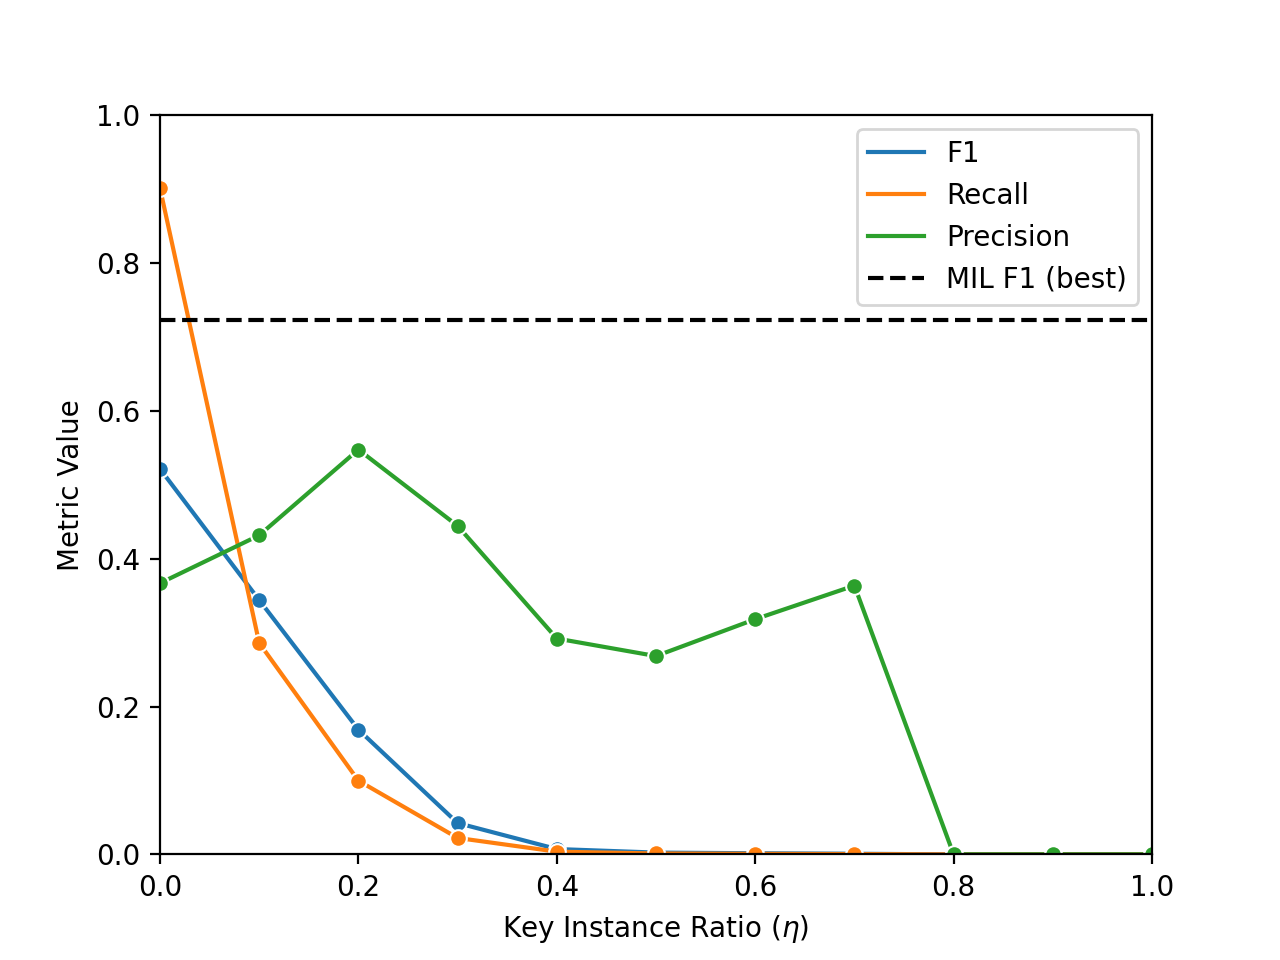

In [5]:
is_df = []
split = "test"
for b_name, res in baselines.items():
    if "mil" in b_name.lower():
        is_df.append([
            float(b_name.split("_")[0].split("-")[-1]),
            res[split]['f1'],
            res[split]['precision'],
            res[split]['recall']
        ])
is_df = pd.DataFrame(is_df, columns=["k", "F1", "Precision", "Recall"])

d = pd.melt(
    is_df, 
    id_vars=["k"], 
    value_vars=["F1", "Recall", "Precision"],
    var_name="Metric",
    value_name="Value"
)

g = sns.lineplot(d, x="k", y="Value", hue="Metric", marker="o")
g.axhline(y=0.7235, label="MIL F1 (best)", linestyle="--", color="black")  # hard coded from MIL 0.6. Test score. Model chosen from val set.
g.set(ylim=(0, 1), xlim=(0, 1))
g.set_xlabel("Key Instance Ratio ($\eta$)")
g.set_ylabel("Metric Value")

g.legend()


# MIL Key Instance Ratio ($\eta$) Sweep

Load training experiments from Wandb API. `eval/f1` is overridden by test evaluation. Load correct `eval` from disk.

In [6]:
model_dir = f"{os.environ['MINERVA_HOME']}/models/mil_models"

api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("aadelucia/Minerva", filters = {"group": "MIL-Min10-v2"})

summary_list, config_list, name_list = [], [], []
data = []
for run in runs: 
    row = {}
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    # eval from wandb is actually test
    row.update({k.replace('eval', 'test'):v for k,v in run.summary._json_dict.items()})
    
    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    row.update({k: v for k,v in run.config.items() if not k.startswith('_')})
    
    # .name is the human-readable name of the run.
    row["name"] = run.name
    
    # Fix eval
    with open(f"{model_dir}/{row['output_dir'].split('/')[-1]}/eval_results.json") as f:
        eval_res = json.load(f)
        row.update({k.replace('_', '/'):v for k,v in eval_res.items()})
        
    # Add 
    data.append(row)

runs_df = pd.DataFrame(data).sort_values(by="eval/f1", ascending=False)


In [7]:
runs_df

,gradients/instance_model.model.roberta.encoder.layer.9.intermediate.dense.weight,gradients/instance_model.model.roberta.encoder.layer.8.attention.self.query.bias,gradients/instance_model.model.roberta.encoder.layer.7.attention.self.value.bias,gradients/instance_model.model.roberta.encoder.layer.9.attention.output.dense.weight,gradients/instance_model.model.roberta.encoder.layer.9.output.LayerNorm.bias,gradients/instance_model.model.roberta.encoder.layer.1.attention.self.query.weight,gradients/instance_model.model.roberta.encoder.layer.3.attention.output.LayerNorm.weight,gradients/instance_model.model.roberta.encoder.layer.4.attention.self.value.bias,gradients/instance_model.model.roberta.encoder.layer.6.intermediate.dense.weight,gradients/instance_model.model.roberta.encoder.layer.11.attention.self.query.bias,...,per_device_train_batch_size,name,epoch,eval/f1,eval/loss,eval/precision,eval/recall,eval/runtime,eval/samples/per/second,eval/steps/per/second
3,"{'_type': 'histogram', 'bins': [-0.33378848433...","{'values': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1...","{'bins': [-0.22143268585205078, -0.21352700889...","{'_type': 'histogram', 'bins': [-0.06557440757...","{'values': [1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 3, 0...","{'values': [1, 0, 3, 1, 0, 1, 1, 1, 4, 0, 2, 3...","{'_type': 'histogram', 'bins': [-0.44902324676...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'bins': [-2.32788085937...","{'_type': 'histogram', 'bins': [-0.00305374246...",...,5,finetune-0.4,15.76,0.772329,0.521522,0.770556,0.774689,327.1338,40.797,1.021
9,"{'bins': [-0.021992413327097893, -0.0206240341...","{'_type': 'histogram', 'bins': [-0.00256408471...","{'bins': [-0.01656736060976982, -0.01606737636...","{'_type': 'histogram', 'bins': [-0.00455435551...","{'_type': 'histogram', 'bins': [-0.00760317221...","{'_type': 'histogram', 'values': [3, 0, 0, 0, ...","{'_type': 'histogram', 'bins': [-0.01599496416...","{'bins': [-0.03507433086633682, -0.03393872454...","{'values': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...",...,5,finetune-0.3,14.71,0.771803,0.492273,0.770360,0.781358,318.7855,41.865,1.048
2,"{'_type': 'histogram', 'bins': [-0.03172678127...","{'bins': [-0.0008264876087196171, -0.000801217...","{'values': [1, 0, 0, 0, 2, 1, 0, 0, 0, 0, 1, 0...","{'_type': 'histogram', 'bins': [-0.00229947059...","{'_type': 'histogram', 'bins': [-0.01512680202...","{'bins': [-0.011464561335742474, -0.0110798431...","{'bins': [-0.015139665454626083, -0.0146111194...","{'_type': 'histogram', 'bins': [-0.03619243949...","{'values': [2, 0, 0, 1, 0, 1, 1, 0, 2, 1, 1, 4...","{'_type': 'histogram', 'values': [1, 1, 1, 0, ...",...,5,finetune-0.6,39.94,0.771488,0.524362,0.768895,0.777162,331.1320,40.304,1.009
10,"{'values': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0...","{'_type': 'histogram', 'bins': [-0.00109006592...","{'values': [3, 1, 0, 0, 0, 0, 1, 1, 2, 2, 4, 3...","{'_type': 'histogram', 'bins': [-0.00405561830...","{'_type': 'histogram', 'bins': [-0.00672688568...","{'values': [1, 2, 0, 1, 0, 0, 1, 1, 2, 3, 4, 5...","{'bins': [-0.045786306262016296, -0.0447456762...","{'_type': 'histogram', 'bins': [-0.03687984496...","{'values': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2...","{'_type': 'histogram', 'values': [2, 0, 0, 1, ...",...,5,finetune-0.5,14.19,0.769180,0.497262,0.766522,0.775288,321.8925,41.461,1.038
7,"{'_type': 'histogram', 'bins': [-0.00464133964...","{'bins': [-0.001113653415814042, -0.0010854455...","{'_type': 'histogram', 'bins': [-0.01736756972...","{'_type': 'histogram', 'bins': [-0.00293366983...","{'_type': 'histogram', 'bins': [-0.03035978600...","{'bins': [-0.02278839610517025, -0.02205472066...","{'values': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2...","{'_type': 'histogram', 'bins': [-0.09713193029...","{'bins': [-0.038602061569690704, -0.0373343341...","{'_type': 'histogram', 'bins': [-0.00011336870...",...,5,finetune-0.7,13.14,0.768876,0.497071,0.767113,0.778286,332.2131,40.173,1.005
5,"{'

How does key instance ratio effect the performance? Base off validation set.

<IPython.core.display.Javascript object>


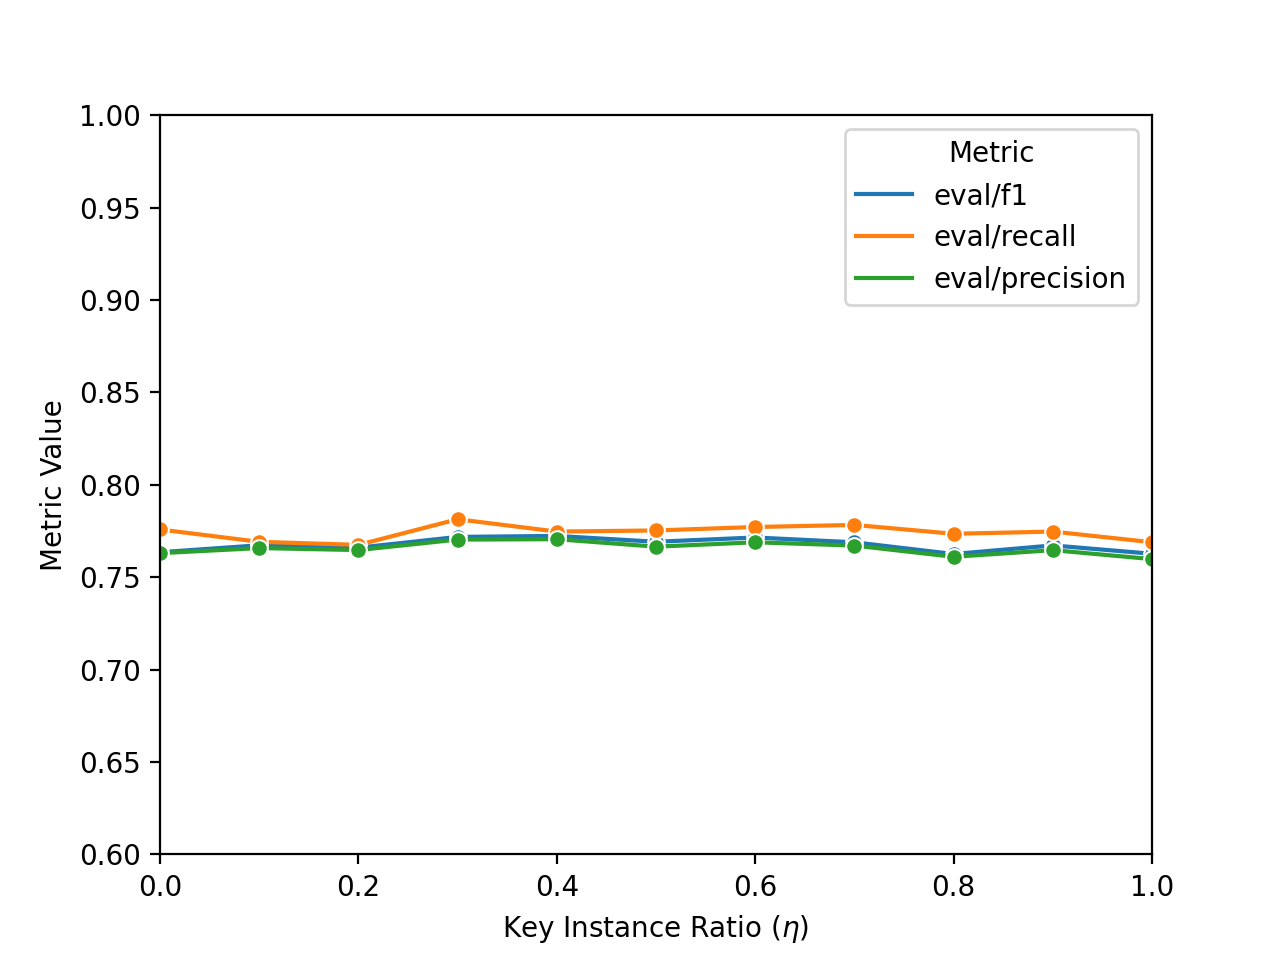

Text(0, 0.5, 'Metric Value')

In [8]:
d = pd.melt(
    runs_df, 
    id_vars=["key_instance_ratio"], 
    value_vars=["eval/f1", "eval/recall", "eval/precision"],
    var_name="Metric",
    value_name="Value"
)

fig = plt.figure(num="eta-sweep")
g2 = fig.gca()
sns.lineplot(d, x="key_instance_ratio", y="Value", hue="Metric", marker="o", ax=g2)
g2.set(ylim=(0.6, 1), xlim=(0, 1))
g2.set_xlabel("Key Instance Ratio ($\eta$)")
g2.set_ylabel("Metric Value")


Table version of the same results. Include

- All baselines
- F1, precision, and recall
- Best MIL run
- MIL max run (i.e, key instance ratio of 0)


In [9]:
out = ""
summary = pd.concat([
    runs_df[runs_df.key_instance_ratio==0],
    runs_df.sort_values(by="eval/f1", ascending=False).head(1)
])
split = "test"
for idx, row in summary.iterrows():
    out += f"MIL (k={row['key_instance_ratio']}) & {row['test/f1']:.2} & {row['test/precision']:.2} & {row['test/recall']:.2} \\\\\n"

for b_name, res in baselines.items():
    b_name = " ".join(b_name.split("_"))
    out += f"{b_name.capitalize()} & {res['test']['f1']:.2} & {res['test']['precision']:.2} & {res['test']['recall']:.2} \\\\\n"

print(out)



MIL (k=0.0) & 0.71 & 0.73 & 0.74 \\
MIL (k=0.4) & 0.73 & 0.73 & 0.74 \\
Mil-i-0.1 results & 0.34 & 0.43 & 0.29 \\
Mil-i-1e+00 results & 0.0 & 0.0 & 0.0 \\
Mil-i-0.5 results & 0.0024 & 0.27 & 0.0012 \\
Mil-i-0e+00 results & 0.52 & 0.37 & 0.9 \\
Ngram results & 0.48 & 0.64 & 0.38 \\
Mil-i-0.2 results & 0.17 & 0.55 & 0.1 \\
Mil-i-0.4 results & 0.0073 & 0.29 & 0.0037 \\
Mil-i-0.9 results & 0.0 & 0.0 & 0.0 \\
Avg-bag results & 0.48 & 0.33 & 0.88 \\
Mil-i-0.8 results & 0.0 & 0.0 & 0.0 \\
Random results & 0.31 & 0.33 & 0.28 \\
Mil-i-0.7 results & 0.00089 & 0.36 & 0.00045 \\
Mil-i-0.6 results & 0.0016 & 0.32 & 0.00078 \\
Mil-i-0.3 results & 0.042 & 0.44 & 0.022 \\
Country random results & 0.5 & 0.54 & 0.46 \\



How many instances at each key instance ratio? Only need for training set. Instances are sampled from the bag, use `--num_tweets_per_day` parameter to set.

Colors from https://seaborn.pydata.org/tutorial/color_palettes.html

In [10]:
data_dir = f"{os.environ['MINERVA_HOME']}/data/premade_mil/minimum_10"
df = pd.read_json(f"{data_dir}/train.jsonl", lines=True)

In [11]:
df

,bag_id,filename,num_instances,label,total_instances,total_eligible_instances,instances
0,2016_09_18_SLE,/home/aadelucia/MIL-civil-unrest/data/tweets_e...,14,0,17,14,"[{'created_at': '2016-09-18 00:01:48+00:00', '..."
1,2015_07_07_MWI,/home/aadelucia/MIL-civil-unrest/data/tweets_e...,218,0,233,218,"[{'created_at': '2015-07-07 00:22:55+00:00', '..."
2,2014_06_18_TZA,/home/aadelucia/MIL-civil-unrest/data/tweets_e...,1000,0,1167,1100,"[{'created_at': '2014-06-18 10:27:13+00:00', '..."
3,2015_08_02_CIV,/home/aadelucia/MIL-civil-unrest/data/tweets_e...,196,0,223,196,"[{'created_at': '2015-08-02 00:05:31+00:00', '..."
4,2015_07_22_MOZ,/home/aadelucia/MIL-civil-unrest/data/tweets_e...,108,0,117,108,"[{'created_at': '2015-07-22 00:01:31+00:00', '..."
...,...,...,...,...,...,...,...
38062,2014_11_29_ZAF,/home/aadelucia/MIL-civil-unrest/data/tweets_e...,1000,1,17113,15825,"[{'created_at': '2014-11-29 16:20:32+00:00', '..."
38063,2014_04_18_LKA,/home/aadelucia/MIL-civil-unrest/data/tweets_e...,962,0,1057,962,"[{'created_at': '2014-04-18 00:05:43+00:00', '..."
38064,2016_11_29_LBY,/home/aadelucia/MIL-civil-unrest/data/tweets_e...,141,1,155,141,"[{'created_at': '2016-11-29 00:06:16+00:00', '..."
38065,2016_08_27_MDG,/home/aadelucia/MIL-civil-unrest/data/tweets_e...,46,0,55,46,"[{'created_at': '2016-08-27 00:25:36+00:00', '..."


In [12]:
max_instances = runs_df['num_tweets_per_day'].iloc[0]  # Should be same for entire dataframe
instances_at_k = []
ratios = np.arange(0.0, 1.1, step=0.1)
for k in ratios:
    raw_values = df.num_instances.map(lambda x: max(int(np.floor(min(x, max_instances) * k)), 1))
    instances_at_k.append([
        k,
        np.mean(raw_values),
        np.std(raw_values),
        np.median(raw_values),
        np.min(raw_values),
        np.max(raw_values)
    ])
instances_at_k = pd.DataFrame(instances_at_k, columns=["k", "avg", "std", "med", "min", "max"])

In [13]:
instances_at_k

,k,avg,std,med,min,max
0,0.0,1.000000,0.000000,1.0,1,1
1,0.1,7.892216,3.376742,10.0,1,10
2,0.2,15.932724,6.573634,20.0,2,20
3,0.3,23.945806,9.804021,30.0,3,30
4,0.4,31.991489,12.990609,40.0,4,40
5,0.5,40.070166,16.134398,50.0,5,50
6,0.6,48.052276,19.402445,60.0,6,60
7,0.7,56.066646,22.628072,70.0,7,70
8,0.8,64.111041,25.820549,80.0,8,80
9,0.9,72.120235,29.058969,90.0,9,90


<IPython.core.display.Javascript object>


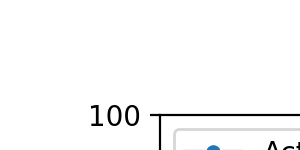

In [14]:
# Create new plot so figures don't overlap
fig = plt.figure(num="eta-sweep-k")
g3 = fig.gca()
sns.lineplot(instances_at_k, x="k", y="avg", marker="o", label="Actual", color="#1f77b4", ax=g3)
g3.fill_between(
    instances_at_k["k"], 
    instances_at_k["avg"] - instances_at_k["std"],
    instances_at_k["avg"] + instances_at_k["std"],
    color="#1f77b4", alpha=0.2
)

# Add expected number of instances
expected = np.array([r*max_instances for r in ratios])
g3.plot(ratios, expected, label="Expected", linestyle="--", marker="o", color="#ff7f0e")

# Format
g3.set(ylim=(0, max_instances), xlim=(0, 1))
g3.set_xlabel("Key Instance Ratio ($\eta$)")
g3.set_ylabel("Avg Number of Instances per Bag ($|K_i|$)")
g3.legend()


# MIL-BI Sweep

In [15]:
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("aadelucia/Minerva", filters = {"group": "MIL-BI-Min10"})

summary_list, config_list, name_list = [], [], []
data = []
for run in runs: 
    row = {}
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    row.update({k.replace('eval', 'test'):v for k,v in run.summary._json_dict.items()})
    
    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    row.update({k: v for k,v in run.config.items() if not k.startswith('_')})
    
    # .name is the human-readable name of the run.
    row["name"] = run.name
    
    # Fix eval
    try:
        with open(f"{model_dir}/{row['output_dir'].split('/')[-1]}/eval_results.json") as f:
            eval_res = json.load(f)
            row.update({k.replace('_', '/'):v for k,v in eval_res.items()})
    except FileNotFoundError as err:
        print(f"{run.name} not done running. Results incomplete.")
    # Add 
    data.append(row)

bi_runs_df = pd.DataFrame(data)

instance-loss-0.75 not done running. Results incomplete.


In [16]:
# Add in the best MIL for 0.0 instance loss
bi_runs_df = pd.concat([
    bi_runs_df,
    runs_df.sort_values(by="eval/f1", ascending=False).head(1)
])

In [17]:
bi_runs_df.sort_values(by="eval/f1", ascending=False)

,test/loss,gradients/instance_model.model.roberta.encoder.layer.1.attention.self.key.bias,gradients/instance_model.model.roberta.encoder.layer.9.attention.self.query.bias,gradients/instance_model.model.roberta.encoder.layer.11.output.LayerNorm.weight,gradients/instance_model.model.roberta.encoder.layer.1.intermediate.dense.bias,gradients/instance_model.model.roberta.encoder.layer.9.attention.output.dense.bias,gradients/instance_model.model.roberta.encoder.layer.9.intermediate.dense.bias,train/epoch,gradients/instance_model.model.roberta.encoder.layer.2.attention.self.key.bias,gradients/instance_model.model.roberta.encoder.layer.6.attention.output.dense.bias,...,train/train_steps_per_second,_wandb,epoch,eval/f1,eval/loss,eval/precision,eval/recall,eval/runtime,eval/samples/per/second,eval/steps/per/second
3,0.555197,"{'_type': 'histogram', 'bins': [-2.98023223876...","{'_type': 'histogram', 'bins': [-0.01425365917...","{'bins': [-0.006871955469250679, -0.0065456023...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'bins': [-0.08001573383...","{'_type': 'histogram', 'bins': [-0.03106082603...",15.76,"{'_type': 'histogram', 'bins': [-8.49831849336...","{'_type': 'histogram', 'bins': [-0.34663259983...",...,2.049,{'runtime': 48648},15.76,0.772329,0.521522,0.770556,0.774689,327.1338,40.797,1.021
1,0.570368,"{'bins': [-1.1641532182693481e-09, -1.12595444...","{'bins': [-0.0005030462052673101, -0.000486762...","{'_type': 'histogram', 'bins': [-0.00394504424...","{'_type': 'histogram', 'bins': [-0.01284719444...","{'_type': 'histogram', 'bins': [-0.00745609169...","{'_type': 'histogram', 'bins': [-0.00695960596...",39.94,"{'_type': 'histogram', 'bins': [-8.38190317153...","{'_type': 'histogram', 'bins': [-0.01411617733...",...,0.805,{'runtime': 120480},39.94,0.771488,0.524362,0.768895,0.777162,327.6343,40.734,1.019
2,0.570368,"{'_type': 'histogram', 'bins': [-1.16415321826...","{'bins': [-0.0005030462052673101, -0.000486762...","{'_type': 'histogram', 'bins': [-0.00394504424...","{'_type': 'histogram', 'bins': [-0.01284719444...","{'values': [1, 0, 0, 2, 1, 0, 2, 0, 4, 5, 6, 4...","{'values': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",39.94,"{'_type': 'histogram', 'bins': [-8.38190317153...","{'bins': [-0.014116177335381508, -0.0136686405...",...,0.805,{'runtime': 120484},39.94,0.771488,0.524362,0.768895,0.777162,323.1472,41.300,1.034
3,0.570368,"{'values': [1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0...","{'_type': 'histogram', 'bins': [-0.00050304620...","{'_type': 'histogram', 'bins': [-0.00394504424...","{'_type': 'histogram', 'bins': [-0.01284719444...","{'_type': 'histogram', 'bins': [-0.00745609169...","{'_type': 'histogram', 'bins': [-0.00695960596...",39.94,"{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'bins': [-0.01411617733...",...,0.807,{'runtime': 120178},39.94,0.771488,0.524362,0.768895,0.777162,319.0292,41.833,1.047
0,0.514062,"{'bins': [-8.149072527885437e-10, -7.803464541...","{'_type': 'histogram', 'bins': [-0.00080056244...","{'bins': [-0.0063304295763373375, -0.006163482...","{'values': [1, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 1...","{'values': [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0...","{'_type': 'histogram', 'bins': [-0.00243735453...",15.76,"{'_type': 'histogram', 'values': [1, 0, 1, 0, ...","{'_type': 'histogram', 'bins': [-0.00903053209...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>


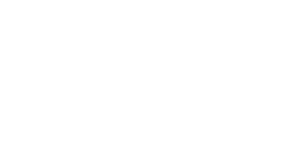

Text(0, 0.5, 'Metric Value')

In [18]:
d = pd.melt(
    bi_runs_df, 
    id_vars=["instance_level_loss"], 
    value_vars=["eval/f1", "eval/recall", "eval/precision"],
    var_name="Metric",
    value_name="Value"
)

# Create new plot so figures don't overlap
fig = plt.figure(num="eta-sweep-instance-only")
g4 = fig.gca()

sns.lineplot(d, x="instance_level_loss", y="Value", hue="Metric", marker="o", ax=g4)
g4.set(ylim=(0.6, 1), xlim=(0, 1))
g4.set_xlabel("Instance Loss Weight ($\beta$)")
g4.set_ylabel("Metric Value")
